# Perceptron



Objectif : programmation d'un perceptron linéaire simple et test sur des :

    - données linéairement séparables (linear)
    - données concentriques non linéairement séparables (twocircles)
    - données en croissant non linéairement séparables (moon)

Un perceptron est une fonction du type $f(w^Tx+b)$, qui calcule une combinaison linéaire des entrées. Le vecteur $w$ est ajusté à partir d'une base d'apprentissage. Le biais $b$ peut être vu comme un poids supplémentaire, relié à une entrée égale à 1.

En classification, une fonction softmax produit la classe $softmax(w^Tx+b)$.


## Paramètres globaux

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

''' 
-------------------------------------------------------------------------
Paramètres du réseau
-------------------------------------------------------------------------
'''    
# Taille des batchs par apprentissage
batch_size = 100  

# Nombre d'itérations
num_epochs = 400

''' 
-------------------------------------------------------------------------
Paramètres du problème
-------------------------------------------------------------------------
'''   
# Nombre de classes
num_labels = 2 


# Nombre de descripteurs
num_features = 2

fichiers_train = ['../data/linear_data_train.csv','../data/twocircles_data_train.csv','../data/moon_data_train.csv']
fichiers_test = ['../data/linear_data_eval.csv','../data/twocircles_data_eval.csv','../data/moon_data_eval.csv']


Définition d'une fonction utile pour le chargement des données

In [2]:
# Extraction des données à partir de lignes label, desc1... descn en un format compatible
def extract_data(filename):

    labels = []
    features = []

    for line in open(filename):
        row = line.split(",")
        # Les labels sont des entiers
        labels.append(int(row[0]))
        # les descripteurs sont des réels
        features.append([float(x) for x in row[1:]])

    # Conversion en des types  matrices numpy
    features_np = np.matrix(features).astype(np.float32)

    labels_np = np.array(labels).astype(dtype=np.uint8)
    labels_onehot = (np.arange(num_labels) == labels_np[:, None]).astype(np.float32)

    return features_np,labels_onehot

Définition de la fonction d'affichage graphique des résultats (frontière de séparation et classes)

In [3]:
def plotResults(ax,X,Y,model,titre):
    # rectangle de tracé
    mins = np.amin(X,0); 
    mins = mins - 0.1*np.abs(mins);
    maxs = np.amax(X,0); 
    maxs = maxs + 0.1*maxs;

    ## Génération d'une grille
    xs,ys = np.meshgrid(np.linspace(mins[0,0],maxs[0,0],300),np.linspace(mins[0,1], maxs[0,1], 300));

    # Modèle sur la grille
    Z = np.argmax(model.predict(np.c_[xs.flatten(), ys.flatten()]), axis=-1)
    Z=Z.reshape(xs.shape[0],xs.shape[1])
    
    # conversion one shot vecteur
    labelY = np.matrix(Y[:, 0]+2*Y[:, 1])
    labelY = labelY.reshape(np.array(X[:, 0]).shape)

    ax.contourf(xs, ys, Z, cmap=plt.cm.magma,alpha=.5)
    ax.scatter(np.array(X[:, 0]),np.array(X[:, 1]),c= np.array(labelY),s=20,cmap=colors.ListedColormap(['red', 'green']))
    ax.set_title(titre)
    plt.tight_layout()


In [4]:
# Taille des batchs par apprentissage
batch_size = 100  


# Nombre d'itérations
num_epochs = 1000

# learning rate
lr = 0.01

Définition du modèle $y=softmax(w^Tx+b)$

In [7]:
# Définition du modèle 
model = Sequential([
    Dense(128, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
model.summary()

/Users/neil/miniconda3/envs/AI_ML/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-30 16:36:34.853867: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-09-30 16:36:34.853902: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-30 16:36:34.853909: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-30 16:36:34.853926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-30 16:36:34.853940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,770 (34.26 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

Optimisation et prédiction

In [1]:
# Fonction de perte et procédure d'optimisation : entropue croisée binaire et Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['acc'])
model.summary()


NameError: name 'model' is not defined

Entraînement et affichage des résultats

2024-09-30 16:36:39.864085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step


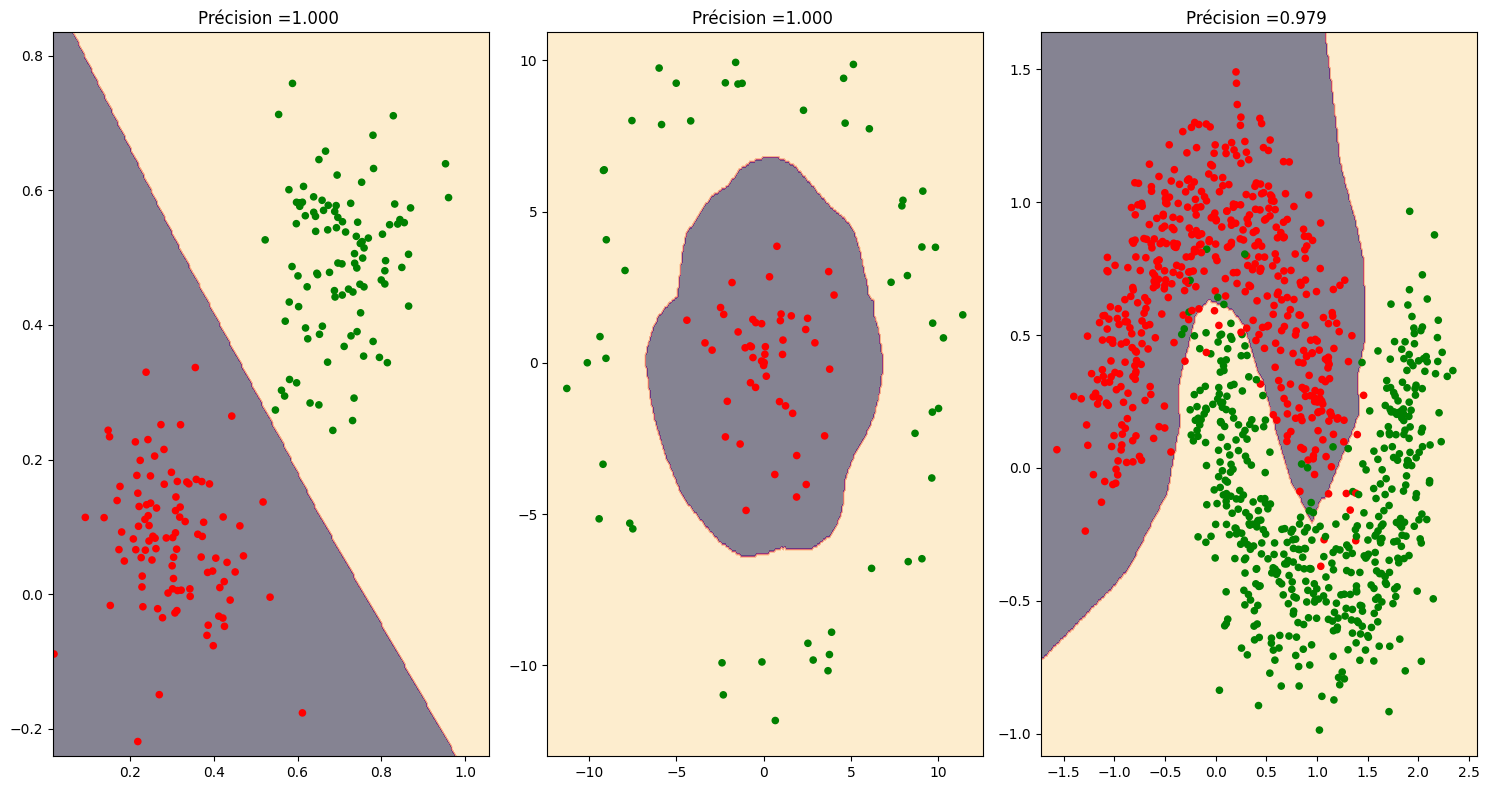

In [9]:
fig,axs = plt.subplots(1, 3,figsize=(15,8))
for i,name_train,name_test in zip ([0,1,2],fichiers_train,fichiers_test):
    train_data,train_labels = extract_data(name_train)
    test_data, test_labels = extract_data(name_test)
    train_size,num_features = train_data.shape

    # Entraînement
    hist=model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,verbose=0)
    titre= "Précision ={0:5.3f} ".format(hist.history.get('accuracy')[-1])
    plotResults(axs[i],test_data, test_labels, model, titre)
            